# NEU Surface Defect Dataset

### Dataset Details
The original dataset contains 1800 images of 6 types of surface defects in hot-rolled steel strip. The images we will be working with are RGB bitmap images with the class of the defect noted as a two-character code in the filename. The codes and defect types are noted below:
- Cr: Crazing
- In: Inclusion
- Pa: Patches
- PS: Pitted Surface
- RS: Rolled-in Scale
- Sc: Scratch

** The details about how to prepare data can be check via Andrew's tutorial [here](https://github.com/holmgroup/NextGen2020/blob/master/notebooks/0.0_Loading_NEU_Data.ipynb).

# Images Representation - Brightness Histograms

### Exercise Goals
1. Load pre-stored dataset/dataframe and divid into sub-classes
2. Image preparation and visulization
3. Compute and store brightness histograms for all images
4. Compute average brightness histogram for each class
5. Use OpenCV library to process images

** I'll assume that everyone follows the steps which Andrew taught you with. The following experiments are built on the previous blocks and modules without changing anything including variables name and so on. We'll have different stategies to approach and solve the problems. Hence, my tutorial is not the only one solution. You can do whatever you want to achieve your goal but the logic behind them is always the same.

## 1. Load pre-stored dataset/dataframe and divid into sub-classes

In this section, we'll load pre-stored dataframe, and divide it into 6 sub-class datasets based on their labels. 

In [1]:
# import libraries that we'll use

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from sklearn.utils import shuffle

# Jupyter magic command
%matplotlib inline

In [2]:
# load pre-stored data
DF_PATH = os.path.join('..', 'data', 'NEU_dataframe.pkl')
df = pd.read_pickle(DF_PATH)

# visualize dataframe
df.head()

,image_path,label
0,../data/NEU-CLS/Cr_1.bmp,Cr
1,../data/NEU-CLS/Cr_10.bmp,Cr
2,../data/NEU-CLS/Cr_100.bmp,Cr
3,../data/NEU-CLS/Cr_101.bmp,Cr
4,../data/NEU-CLS/Cr_102.bmp,Cr


First, we need to know 
1. the number of all images 
2. the number of sub-classes
3. the number of images in each sub-class

In [3]:
# 1. number of all images
n_images = len(df)
print("number of all images: ", n_images)

# 2. number of sub-classes
subset = df.groupby('label', as_index=False)
n_groups = len(subset)
print("number of sub-classes: ", n_groups)

# 3. number of images in one group - 'Cr'
df_Cr = subset.get_group('Cr')
n_Cr = len(df_Cr)
print("number of images in Cr: ", n_Cr)

number of all images:  1800
number of sub-classes:  6
number of images in Cr:  300


In [4]:
# check sub-class dataframe
df_Cr.head()

,image_path,label
0,../data/NEU-CLS/Cr_1.bmp,Cr
1,../data/NEU-CLS/Cr_10.bmp,Cr
2,../data/NEU-CLS/Cr_100.bmp,Cr
3,../data/NEU-CLS/Cr_101.bmp,Cr
4,../data/NEU-CLS/Cr_102.bmp,Cr


In [5]:
# the other sub-classes are processed in the same way
df_In = subset.get_group('In')
n_In = len(df_In)
print("number of images in In: ", n_In)

df_Pa = subset.get_group('Pa')
n_Pa = len(df_Pa)
print("number of images in Pa: ", n_Pa)

df_PS= subset.get_group('PS')
n_PS = len(df_PS)
print("number of images in PS: ", n_PS)

df_RS = subset.get_group('RS')
n_RS = len(df_RS)
print("number of images in RS: ", n_RS)

df_Sc = subset.get_group('Sc')
n_Sc = len(df_Sc)
print("number of images in Sc: ", n_Sc)

number of images in In:  300
number of images in Pa:  300
number of images in PS:  300
number of images in RS:  300
number of images in Sc:  300


## 2. Image preparation and visulization

Previously, we're able to get image path and its corresponding label.

In this section, we'll load images from dataframe, and check details about images.

In [6]:
# Review: get_files function

# Let's review a helper function to help us find data files
def get_files(file_directory, extension='*.bmp'):
    """
    Arguments:
        file_directory: path to directory to search for files
        extension: desired file type, default *.bmp (bitmap)
    
    Return:
        files: list of files in file_directory with extension
    """
    files = glob.glob(os.path.join(file_directory, extension))
    return files

In [7]:
# get image path (directory for image)
DATA_PATH = os.path.join('..', 'data', 'NEU-CLS')
image_paths = get_files(DATA_PATH)

print(DATA_PATH)
print(image_paths[0:5])

../data/NEU-CLS
['../data/NEU-CLS/Cr_1.bmp', '../data/NEU-CLS/Cr_10.bmp', '../data/NEU-CLS/Cr_100.bmp', '../data/NEU-CLS/Cr_101.bmp', '../data/NEU-CLS/Cr_102.bmp']


### Read image
we can read image via several methods:
1. PIL(pillow)
2. skimage
3. matplotlib.image
4. scipy.misc
5. opencv

In order to follow Andrew's tutorial, PIL will be used here (even though my top suggestion will be opencv). Compared with opencv, PIL is much lighter and faster but not so powerful. The only slight difference is that the return type is 'Object', not numpy matrix if using PIL.Image.open()to read image.

In [8]:
PIL.Image.open?

Signature: PIL.Image.open(fp, mode='r')
Docstring:
Opens and identifies the given image file.

This is a lazy operation; this function identifies the file, but
the file remains open and the actual image data is not read from
the file until you try to process the data (or call the
:py:meth:`~PIL.Image.Image.load` method).  See
:py:func:`~PIL.Image.new`. See :ref:`file-handling`.

:param fp: A filename (string), pathlib.Path object or a file object.
   The file object must implement :py:meth:`~file.read`,
   :py:meth:`~file.seek`, and :py:meth:`~file.tell` methods,
   and be opened in binary mode.
:param mode: The mode.  If given, this argument must be "r".
:returns: An :py:class:`~PIL.Image.Image` object.
:exception FileNotFoundError: If the file cannot be found.
:exception PIL.UnidentifiedImageError: If the image cannot be opened and
   identified.
:exception ValueError: If the ``mode`` is not "r", or if a ``StringIO``
   instance is used for ``fp``.
File:      ~/python_venvs/nextgen/l

<class 'PIL.BmpImagePlugin.BmpImageFile'>
<class 'numpy.ndarray'>
(200, 200)


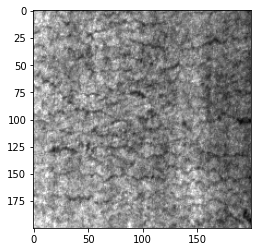

In [9]:
# read single image
image = PIL.Image.open(image_paths[0])
print(type(image)) 

# convert type
image = np.array(image)
print(type(image))

# the size of image
print(image.shape)

# visualize image using plt.imshow
plt.imshow(image, cmap='gray')

### Question 1: 
How to read an image using other four methods？

### Question 2: 
How to read all images with using ‘for’ loop ？

### A much faster way without 'for' loop:

In [10]:
# define function to read all image from dataframe

def load_image(image_paths):
    images = [np.array(PIL.Image.open(p)) for p in image_paths]
    return images

# using function to read all images
images = load_image(image_paths)

type(images)

list

In [11]:
# add pixel values of images as a new column to the dataframe
df['image'] = images
df.head()


,image_path,label,image
0,../data/NEU-CLS/Cr_1.bmp,Cr,"[[186, 175, 173, 196, 190, 188, 172, 174, 192,..."
1,../data/NEU-CLS/Cr_10.bmp,Cr,"[[163, 160, 148, 142, 174, 191, 207, 215, 176,..."
2,../data/NEU-CLS/Cr_100.bmp,Cr,"[[127, 106, 104, 118, 115, 94, 112, 105, 100, ..."
3,../data/NEU-CLS/Cr_101.bmp,Cr,"[[173, 164, 146, 147, 178, 170, 170, 183, 171,..."
4,../data/NEU-CLS/Cr_102.bmp,Cr,"[[163, 179, 169, 157, 161, 181, 168, 130, 117,..."


In [12]:
# dataframe for each sub-class can be created in the same manner like section 1
df_Cr.head()

,image_path,label
0,../data/NEU-CLS/Cr_1.bmp,Cr
1,../data/NEU-CLS/Cr_10.bmp,Cr
2,../data/NEU-CLS/Cr_100.bmp,Cr
3,../data/NEU-CLS/Cr_101.bmp,Cr
4,../data/NEU-CLS/Cr_102.bmp,Cr


In [13]:
# get image path from dataframe of Cr
image_path_Cr = df_Cr['image_path']
len(image_path_Cr)

300

In [14]:
# using function to load images of Cr
images_Cr = load_image(image_path_Cr)

In [15]:
# add pixel values of Cr into dataframe of Cr
df_Cr['image'] = images_Cr
df_Cr.head()

<ipython-input-15-18965f861a5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Cr['image'] = images_Cr


,image_path,label,image
0,../data/NEU-CLS/Cr_1.bmp,Cr,"[[186, 175, 173, 196, 190, 188, 172, 174, 192,..."
1,../data/NEU-CLS/Cr_10.bmp,Cr,"[[163, 160, 148, 142, 174, 191, 207, 215, 176,..."
2,../data/NEU-CLS/Cr_100.bmp,Cr,"[[127, 106, 104, 118, 115, 94, 112, 105, 100, ..."
3,../data/NEU-CLS/Cr_101.bmp,Cr,"[[173, 164, 146, 147, 178, 170, 170, 183, 171,..."
4,../data/NEU-CLS/Cr_102.bmp,Cr,"[[163, 179, 169, 157, 161, 181, 168, 130, 117,..."


In [16]:
# images values can be added into dataframe for the other five dataframes
image_path_In = df_In['image_path']
images_In = load_image(image_path_In)
df_In['image'] = images_In

image_path_Pa = df_Pa['image_path']
images_Pa = load_image(image_path_Pa)
df_Pa['image'] = images_Pa

image_path_PS = df_PS['image_path']
images_PS = load_image(image_path_PS)
df_PS['image'] = images_PS

image_path_RS = df_RS['image_path']
images_RS = load_image(image_path_RS)
df_RS['image'] = images_RS

image_path_Sc = df_Sc['image_path']
images_Sc = load_image(image_path_Sc)
df_Sc['image'] = images_Sc

<ipython-input-16-60e946f10f3f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_In['image'] = images_In
<ipython-input-16-60e946f10f3f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Pa['image'] = images_Pa
<ipython-input-16-60e946f10f3f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

### Question 3: 
How to solve the warning ？

## 3. Compute and store brightness histograms for all images


In this section, we will use brightness histograms to respresent images. Histograms can be seen as feature vectors to represent brightness distribution of images.

Something about a histogram [here](https://en.wikipedia.org/wiki/Histogram) :
A histogram is a graphical display of data using bars of different heights. In a histogram, each bar groups numbers into ranges. Taller bars show that more data falls in that range. A histogram displays the shape and spread of continuous sample data. 

<img src="https://d20khd7ddkh5ls.cloudfront.net/img13_63.jpg" style="zoom:30%" />


In [17]:
# define a function to compute the brightness histogram
# this function takes images and bins as input, and give the histogram as an output

def intensity_distribution(images, bins):    
    X = []
    for image in images:
        counts, bins = np.histogram(image, bins=bins, range=(0,255), density=True)
        X.append(counts)
    return np.array(X)    


Using X_intensity to store the histogram features

In [18]:
# convert list to array
images = np.array(images)
print("shape of images: ", images.shape)

# bins are used to set the size of histogram
intensity_bins = 256

# get the histogram of all images
X_intensity = intensity_distribution(images, bins=intensity_bins)
print("shape of X_intensity: ", X_intensity.shape)

shape of images:  (1800, 200, 200)
shape of X_intensity:  (1800, 256)


In [19]:
# add histograms of images as a new column to the dataframe
df['histogram'] = list(X_intensity)
df.head()

,image_path,label,image,histogram
0,../data/NEU-CLS/Cr_1.bmp,Cr,"[[186, 175, 173, 196, 190, 188, 172, 174, 192,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,../data/NEU-CLS/Cr_10.bmp,Cr,"[[163, 160, 148, 142, 174, 191, 207, 215, 176,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,../data/NEU-CLS/Cr_100.bmp,Cr,"[[127, 106, 104, 118, 115, 94, 112, 105, 100, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,../data/NEU-CLS/Cr_101.bmp,Cr,"[[173, 164, 146, 147, 178, 170, 170, 183, 171,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,../data/NEU-CLS/Cr_102.bmp,Cr,"[[163, 179, 169, 157, 161, 181, 168, 130, 117,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [20]:
# check the histogram in dataframe
idx = 0
df.loc[idx,'histogram']

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

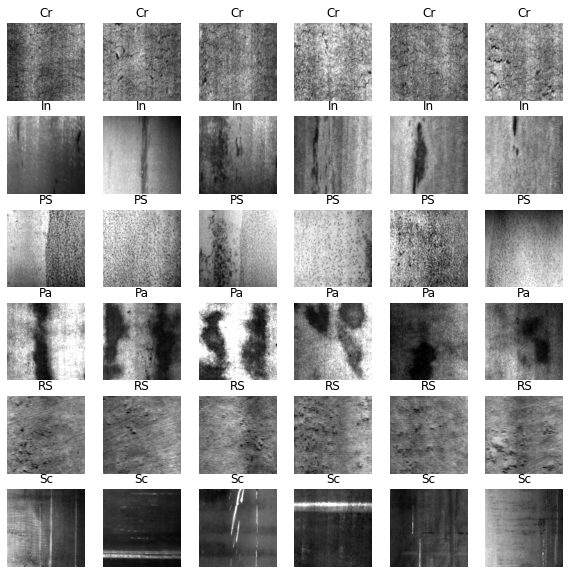

In [21]:
# image visulization

# Randomly sample from each group
# We'll use a cool trick called a lambda function

sample_count = 6   # pick 6 samples
replace = True      # sample with replacement

L = lambda x: x.loc[np.random.choice(x.index, sample_count, replace),:]

subset = df.groupby('label', as_index=False)
subset = subset.apply(L)

# 6 groups (rows)
# 6 samples per group (columns)

fig, axes = plt.subplots(ncols=sample_count, nrows=n_groups, figsize=(10,10))

for ax, image_path, label in zip(axes.flatten(), subset.image_path, subset.label):
    image = PIL.Image.open(image_path)
    ax.imshow(image, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

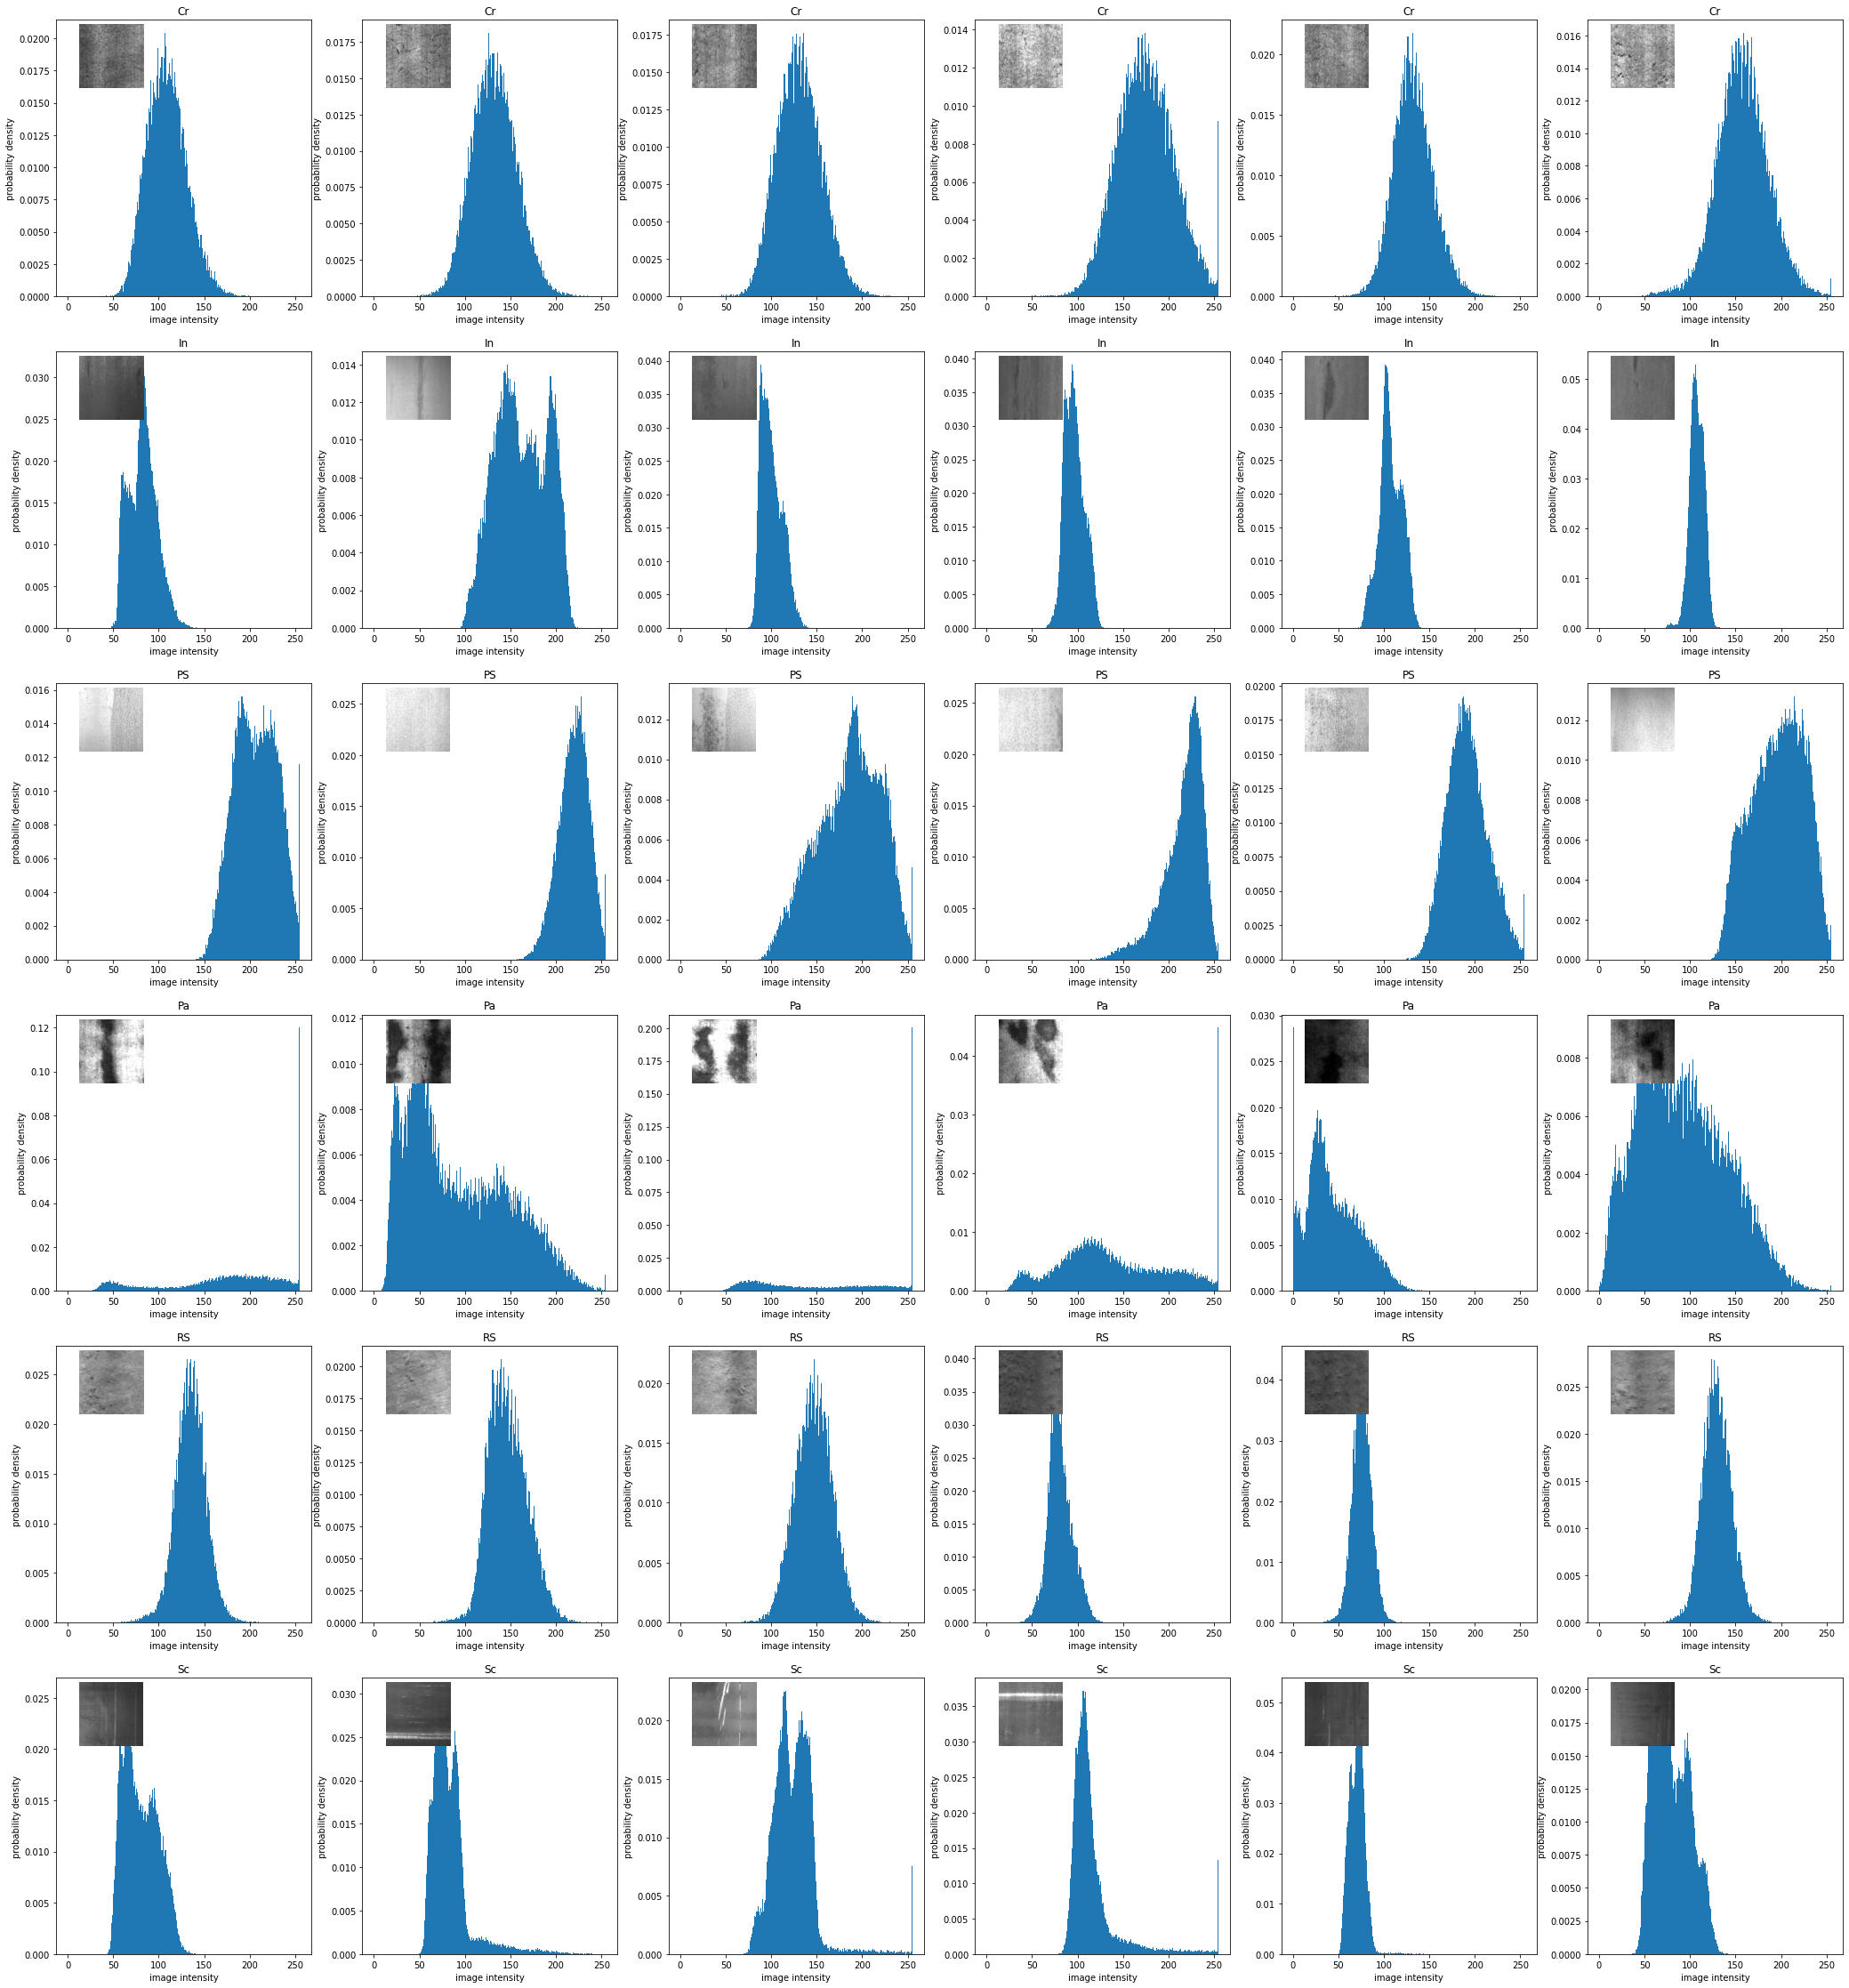

In [22]:
# histogram visulization

from mpl_toolkits.axes_grid1.inset_locator import inset_axes 

fig, axes = plt.subplots(ncols=sample_count, nrows=n_groups, figsize=(36,40))

# set size of bins
bins = np.arange(0,256)

for ax, image_path, label in zip(axes.flatten(), subset.image_path, subset.label):
    
    image = PIL.Image.open(image_path)
    image = np.array(image)
    
    ax.hist(image.flat, bins=bins, density=True)
    ax.set_title(label)
    ax.set_xlabel('image intensity') 
    ax.set_ylabel('probability density')
    
    # insert image into histogram
    i = inset_axes(ax,
                   width="40%", # width = 30% of parent_bbox 
                   height=1., # height : 1 inch
                   loc=2)
    
    i.imshow(image, cmap='gray', vmin=np.min(bins), vmax=np.max(bins)) 
    i.axis('off');
    

## 4. Compute average brightness histogram for each class

For the sake of convience, dataframe for sub-classes are already created, and average brightness histogram for each class can be easily computed. The follow example shows how to compute average brightness histogram for Cr. The other five classes of defect can be computed in the same way.


In [23]:
# dataframe for sub-class Cr
df_Cr.head()

,image_path,label,image
0,../data/NEU-CLS/Cr_1.bmp,Cr,"[[186, 175, 173, 196, 190, 188, 172, 174, 192,..."
1,../data/NEU-CLS/Cr_10.bmp,Cr,"[[163, 160, 148, 142, 174, 191, 207, 215, 176,..."
2,../data/NEU-CLS/Cr_100.bmp,Cr,"[[127, 106, 104, 118, 115, 94, 112, 105, 100, ..."
3,../data/NEU-CLS/Cr_101.bmp,Cr,"[[173, 164, 146, 147, 178, 170, 170, 183, 171,..."
4,../data/NEU-CLS/Cr_102.bmp,Cr,"[[163, 179, 169, 157, 161, 181, 168, 130, 117,..."


shape of Cr_intensity:  (300, 256)


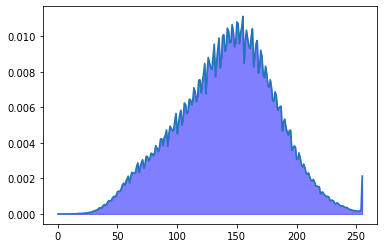

In [24]:
# get the histograms for sub-classes
intensity_Cr = intensity_distribution(np.array(df_Cr['image']), bins=intensity_bins)
print("shape of Cr_intensity: ", intensity_Cr.shape)

# average brightness histogram for sub-classes
ave_intensity_Cr = np.mean(intensity_Cr, axis=0)

# plot average brightness histogram for sub-classes
plt.plot(bins, ave_intensity_Cr, label='Cr')
plt.fill_between(bins, ave_intensity_Cr, interpolate=True, color='blue', alpha=0.5)
plt.show()

### Question 4: 
Can you compute and plot the average brightness histogram for the other five classes ？

## 5. Use OpenCV library to process images

OpenCV (Open Source Computer Vision) is a library of programming functions mainly aimed at real-time computer vision. In simple language it is library used for Image Processing. It is mainly used to do all the operation related to Images.

Check some details about OpenCV [here](https://docs.opencv.org/master/index.html)

### Install OpenCV
let's review how to add individual module to the virtual environment


(NOTICE: directory differs from different machines and you need to check your own files in your computer)



1. Activate our virtual environment with the following commands:

   $ source nextgen/bin/activate
   
2. Go to your default/ home directory:

   (nextgen)$ cd ~
   
3. Navigate to the project directory:
   
   (nextgen)$ cd Documents/NextGen2020

4. Install OpenCV with specific version:

   (nextgen)$ pip install opencv-python==3.4.8.29
   
** Higher version of OpenCV may not be compatible with the existing environment **


In [25]:
# begin to use OpenCV lib by importing cv2
import cv2

### What is Histogram Equalization ?
[Histogram Equalization](https://en.wikipedia.org/wiki/Histogram_equalization) is a computer image processing technique used to improve contrast in images . It accomplishes this by effectively spreading out the most frequent intensity values, i.e. stretching out the intensity range of the image.

### Why is Histogram Equalization ?
Histogram equalization assigns the intensity values of pixels in the input image such that the output image contains a uniform distribution of intensities. It improves contrast and obtain a uniform histogram. This technique can be used on a whole image or just on a part of an image.

### Simple Example helps you get the sense behind this processing :

<img src="https://upload.wikimedia.org/wikipedia/commons/0/08/Unequalized_Hawkes_Bay_NZ.jpg" style="zoom:25%" /> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Unequalized_Histogram.svg/1920px-Unequalized_Histogram.svg.png" style="zoom:15%" />

<img src="https://upload.wikimedia.org/wikipedia/commons/b/bd/Equalized_Hawkes_Bay_NZ.jpg" style="zoom:25%" /> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/Equalized_Histogram.svg/1920px-Equalized_Histogram.svg.png" style="zoom:15%" />

** CDF (Cumulative histogram distribution function) gains smoothy steps **


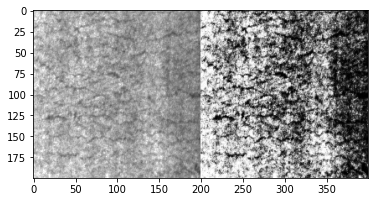

In [26]:
# histogram equlization using cv2

# comparison original image with the image after histogram equalization
index = 0
eq = cv2.equalizeHist(images[index])
plt.imshow(np.hstack([images[index], eq]), cmap='gray')


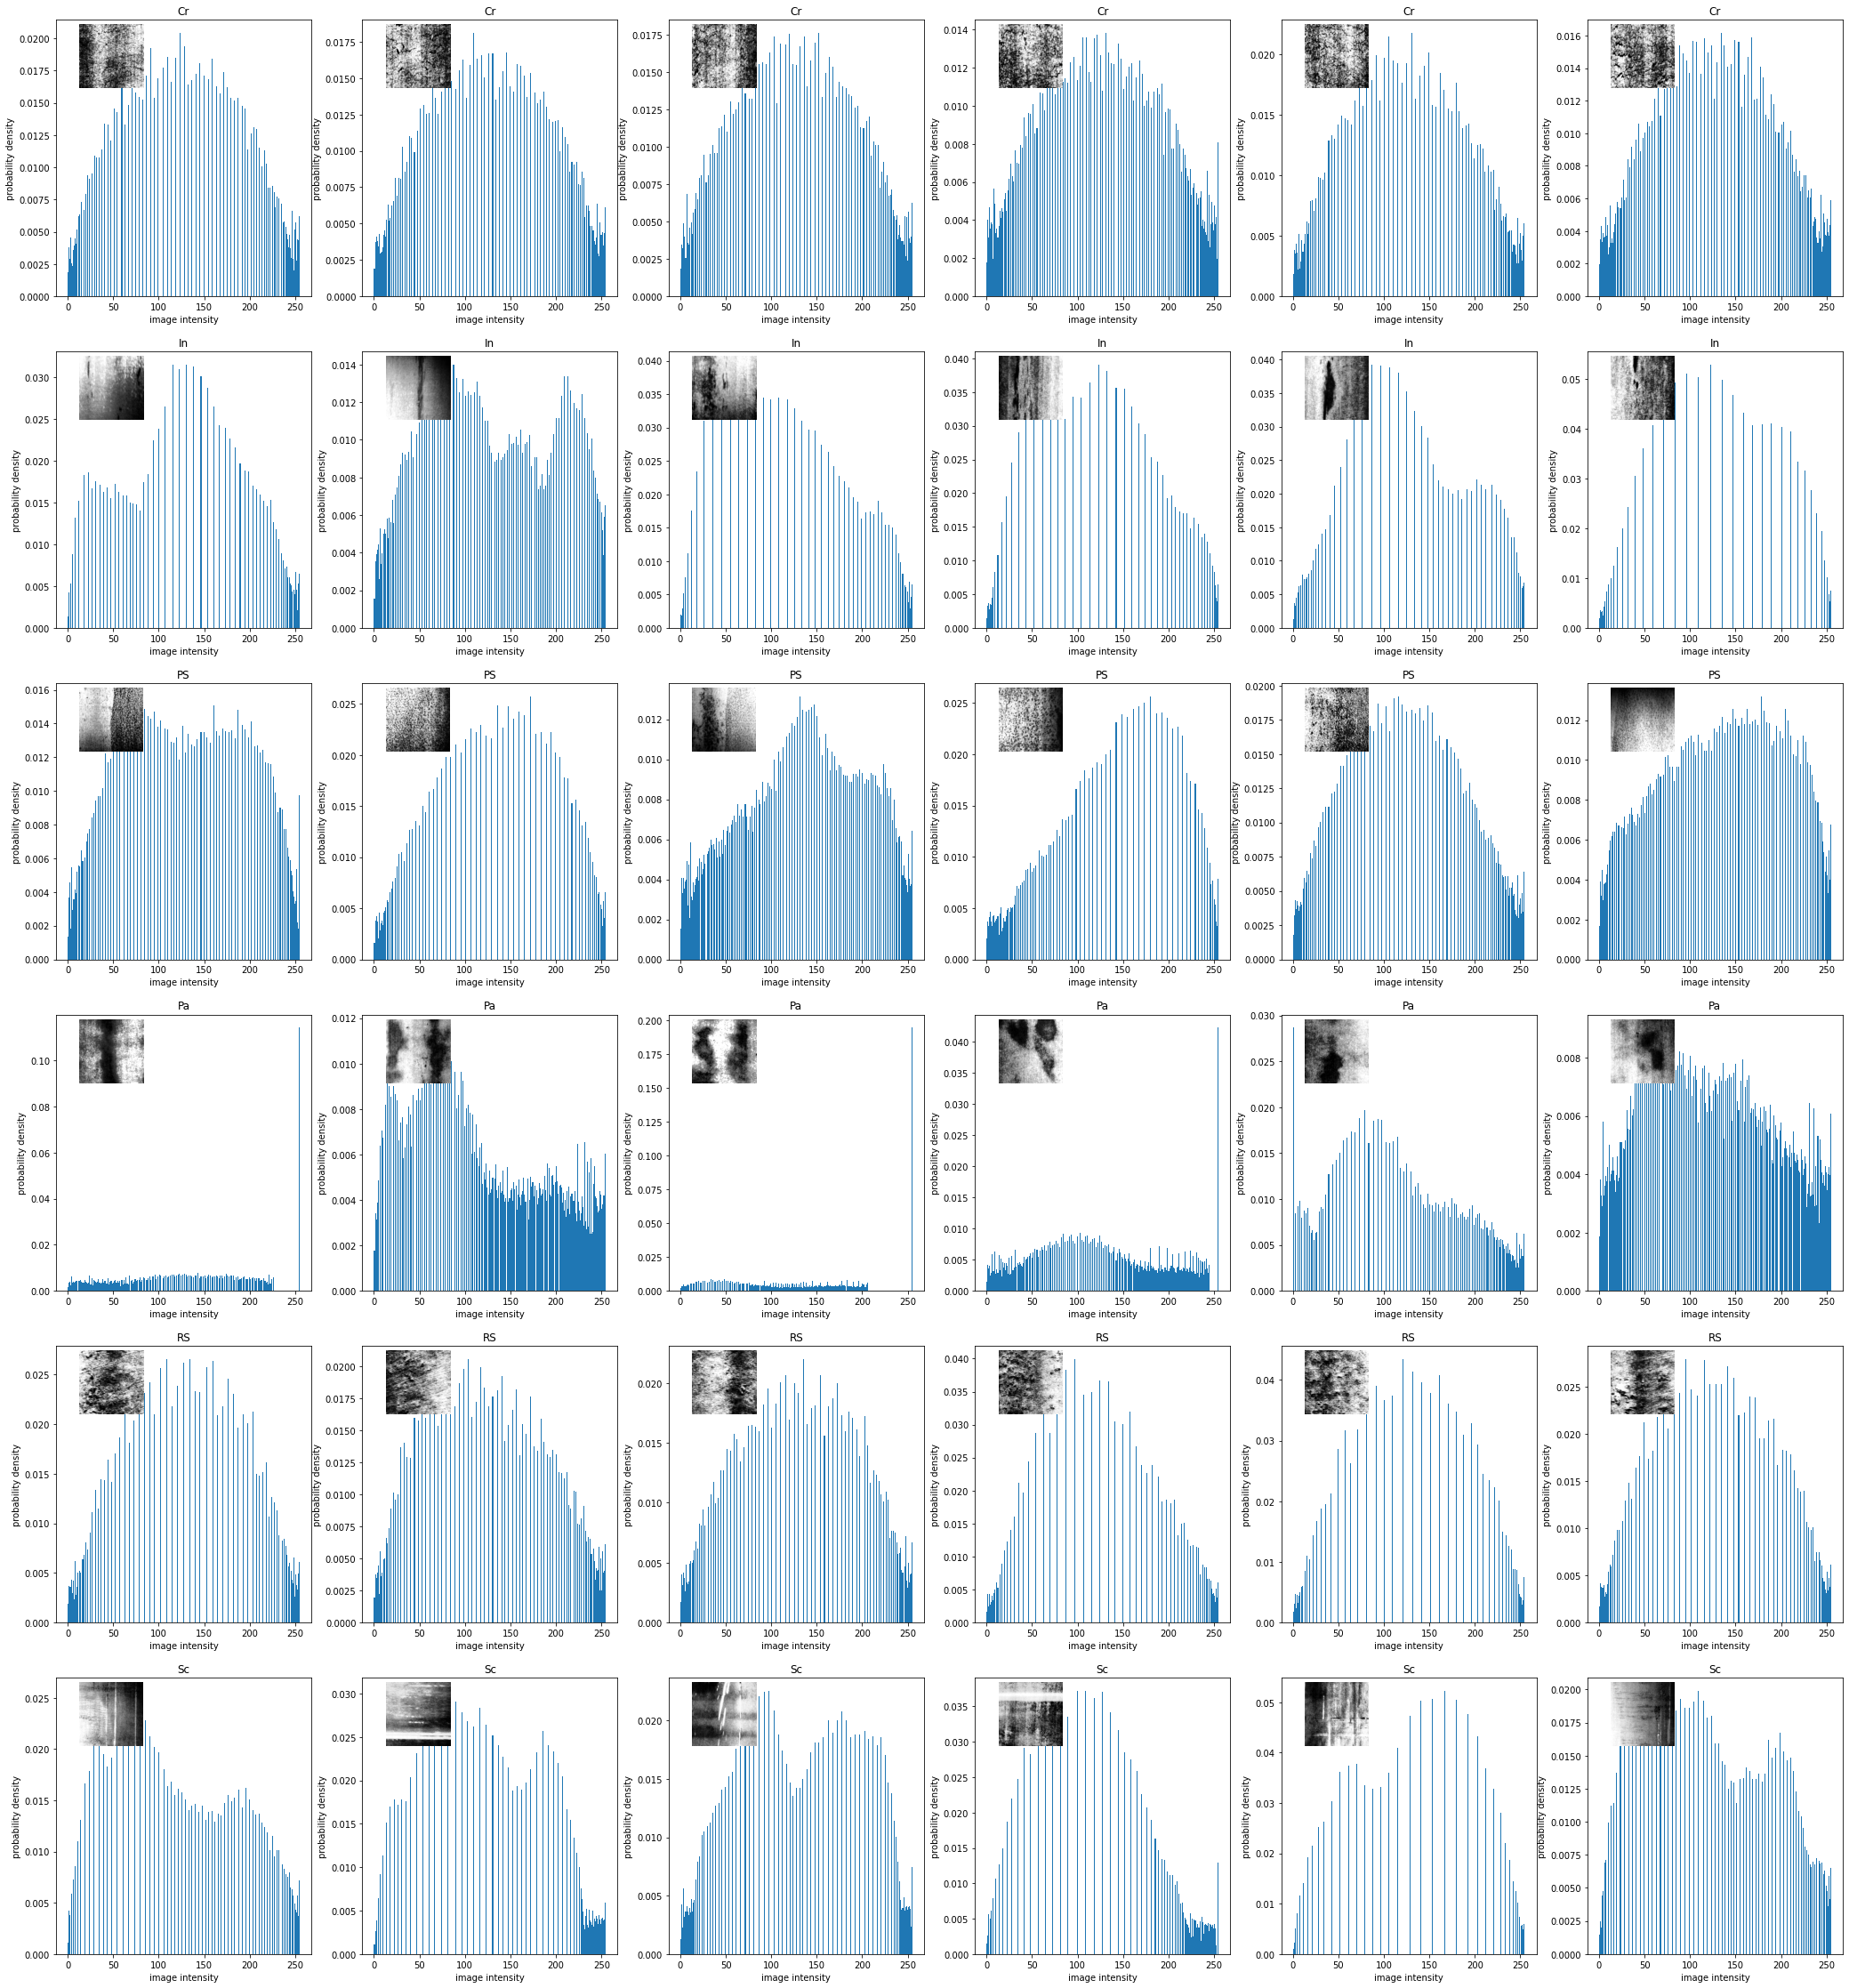

In [27]:
# visualization after histogram equlization 

fig, axes = plt.subplots(ncols=sample_count, nrows=n_groups, figsize=(36,40))

for ax, image_path, label in zip(axes.flatten(), subset.image_path, subset.label):
    
    image = PIL.Image.open(image_path)
    image = np.array(image)
    
    # histogram equalization
    eq = cv2.equalizeHist(image)
    
    ax.hist(eq.flat, bins=bins, density=True)
    ax.set_title(label)
    ax.set_xlabel('image intensity') 
    ax.set_ylabel('probability density')
    
    # insert image into histogram
    i = inset_axes(ax,
                   width="40%", # width = 30% of parent_bbox 
                   height=1., # height : 1 inch
                   loc=2)
    
    i.imshow(eq, cmap='gray', vmin=np.min(bins), vmax=np.max(bins)) 
    i.axis('off');



## Summary
In the second day of tutorial, we learn how to read image, and process image. Sub-class dataframa is also created with adding two extra feature columns, which are image pixel values and brightness histograms. Brightness histograms are calculated for all images, and averaged histograms are computed for 6 sub-classes. Visualization are show for every step as well. At last, we learn how to use OpenCV to process images. OpenCV will be a very useful tool for your further study with computer vision.

** Remember to finish the remaining 4 questions ! You'll learn a lot ! **
